In [2]:
%pylab inline 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent 
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Populating the interactive namespace from numpy and matplotlib


In [3]:
# load the market data
input_source = np.load(open('../deep_learning_trader/NEAT/data_spy.npy','rb'))
to_predict = np.load(open('../deep_learning_trader/NEAT/data_spy_targets.npy','rb'))

In [4]:
input_source = input_source.T
input_source.shape

(123883, 105)

In [15]:
bars_per_episode = 1000

class TradingEnv(gym.Env):
    
    """ This gym implements a simple trading environment for reinforcement learning. """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        self.action_space = spaces.Discrete( 3 )
        self.observation_space= spaces.Box( np.min(input_source, axis=0), 
                                            np.max(input_source, axis=0) )
        self.reset()
        
    def _configure(self, display=None):
        self.display = display

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        
        if self.idx < self.end_idx:
            self.idx += 1
            done = False
        else:
            done = True
        
        info = {}
        
        observation = input_source[self.idx, :]
        
        reward = 0
        
        # execute the action and get the reward
        if action == 0: # buy 
            reward = (to_predict[self.idx] - to_predict[self.idx-1])*10000
        if action == 1: # sell
            reward = (to_predict[self.idx-1] - to_predict[self.idx])*10000
        
        return observation, reward, done, info
  
    def reset(self):
        # reset and return first observation
        self.idx = np.random.randint(0, input_source.shape[0] - bars_per_episode )
        self.end_idx = self.idx + bars_per_episode
        return input_source[self.idx, :]
    
    def _render(self, mode='human', close=False):
        #... TODO
        pass        

In [16]:
env = TradingEnv()

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dense(env.action_space.n, activation='linear'))

memory = SequentialMemory(limit=10000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, 
               nb_actions=env.action_space.n, 
               memory=memory, 
               nb_steps_warmup=10,
               enable_double_dqn=True, 
               enable_dueling_network=True, 
               dueling_type='avg', 
               target_model_update=1e-2, 
               policy=policy)
dqn.compile(Adam(lr=0.002), metrics=['mae'])

In [ ]:
# training is here
h = dqn.fit(env, nb_steps=50000, nb_max_episode_steps=bars_per_episode, visualize=False, verbose=1)
rewards = h.history['episode_reward']

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: 0.0239
10 episodes - episode_reward: 23.850 [-63.500, 177.700] - loss: 4.579 - mean_absolute_error: 2.478 - mean_q: 3.148

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0796
10 episodes - episode_reward: 79.610 [11.500, 176.600] - loss: 4.362 - mean_absolute_error: 3.662 - mean_q: 4.916

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: 0.0013
10 episodes - episode_reward: 1.350 [-146.500, 84.400] - loss: 5.289 - mean_absolute_error: 5.735 - mean_q: 7.988

Interval 4 (30000 steps performed)
 9730/10000 [============================>.] - ETA: 1s - reward: 1.0277e-04

In [ ]:
plot(rewards);

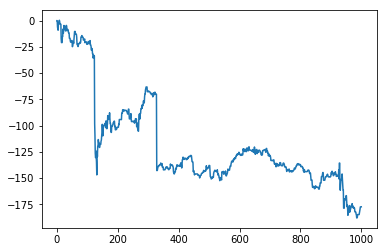

In [9]:
# visualize the behavior for one random episode
observation = env.reset()
done = False
navs = []
while not done:
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action)
    navs.append(reward)

kl = []
t = 0
for n in navs:
    t += n
    kl.append(t)
plot(kl);

In [10]:
# calculate the likelihood of success for any given episode
l = 1000
krl = []
p = pb.ProgressBar(max_value=l)
for i in range(l):
    p.update(i)
    observation = env.reset()
    done = False
    navs = []
    while not done:
        action = dqn.forward(observation)
        observation, reward, done, info = env.step(action)
        navs.append(reward)
    krl.append(sum(navs))
p.finish()

krl = array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

100% (1000 of 1000) |#####################| Elapsed Time: 0:05:28 Time: 0:05:28


Profit likelihood: 48.800%
